In [4]:
import tweepy
import time
import pandas as pd

from IPython.core.display import HTML, display 

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)


OAUTH_KEY = ''
OAUTH_SECRET = ''
ACCESS_TOKEN = ''
ACCESS_TOKEN_SECRET = ''


In [5]:
auth = tweepy.OAuthHandler(OAUTH_KEY, OAUTH_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
graph = Graph(user=NEO4J_USER, password=NEO4J_SECRET)

In [6]:
def get_follwers_by_id(account_id):
    ids = []
    for page in tweepy.Cursor(api.followers_ids, user_id=account_id).pages():
        print("FOLLOWERS: Next page for %s" % account_id)
        ids.extend(page)
    return ids

def get_friends_by_id(account_id):
    ids = []
    for page in tweepy.Cursor(api.friends_ids, user_id=account_id).pages():
        print("FRIENDS: Next page for %s" % account_id)
        ids.extend(page)
    return ids

def get_friends(account):
    ids = []
    for page in tweepy.Cursor(api.friends_ids, screen_name=account).pages():
        print("Next page for %s" % account)
        ids.extend(page)
    return ids

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [4]:
botnet = pd.read_csv('./moscow_ny_bots.csv')

In [6]:
botnet.mean()

Unnamed: 0    2.948457e+02
favorites     5.907807e+01
followers     2.067621e+03
friends       2.805398e+03
id            7.889233e+17
dtype: float64

In [8]:
botnet.std()

Unnamed: 0    1.708186e+02
favorites     4.554484e+01
followers     1.898587e+02
friends       6.387455e+02
id            2.279174e+15
dtype: float64

In [10]:
friend_ids = []
for account in botnet['screen_name'].values:
    friend_ids = list(set(friend_ids) | set(get_friends(account)))

Next page for borisegorov2k3
Next page for alc6jkarpov
Next page for aleefimov7eti
Next page for paveloeyak
Next page for eduardaygalkin
Next page for eduard0uq2zhuk1
.... CUT ....Next page for fedorsubyard
Next page for svetlanmelniko3
Next page for kalashn23274225
Next page for dimad4n5
Next page for petrref7
Next page for antonvor0ez
Next page for kirillpv8gsa


Now get info about all these users

In [13]:
print("We get %s friends" % len(friend_ids))

We get 142225 friends


Now extract user info from these users

In [35]:
possible_bots = []
for group in chunks(friend_ids, 100):
    for user in api.lookup_users(user_ids=list(group)):
        possible_bots.append(user)
        
possible_bots_df = pd.DataFrame([{'name': user.name, 'id': user.id, 'location': user.location, 'screen_name': user.screen_name, 'followers': user.followers_count, 'friends': user.friends_count, 'created_at': user.created_at, 'favorites': user.favourites_count, 'tweets': user.statuses_count} for user in possible_bots])

In [13]:
possible_bots_df.to_csv("./users_pt2.csv", encoding='utf8')
#Here i have pause in my investigation, so i saved and load back all info
#possible_bots_df = pd.read_csv("./users_pt2.csv", encoding='utf8')

In [17]:
locations = possible_bots_df[["id", "location"]].groupby('location').count()

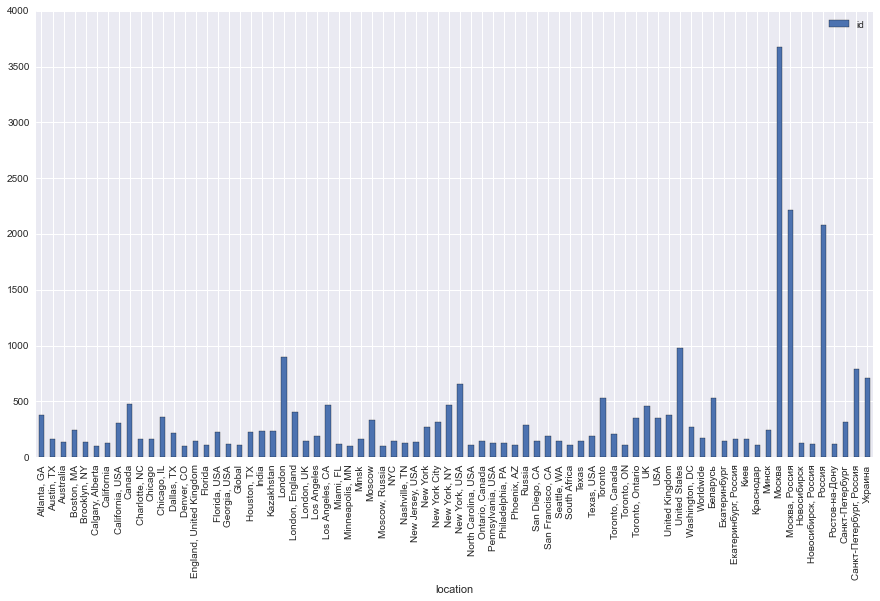

In [22]:
locations[locations['id'] > 100].plot(kind="bar")

### Let's look at moscow users

In [15]:
moscow_users = possible_bots_df[(possible_bots_df["location"] == u'Москва') & (possible_bots_df["id"] > 6 * 1e17)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11080d190>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10dd5f350>]], dtype=object)

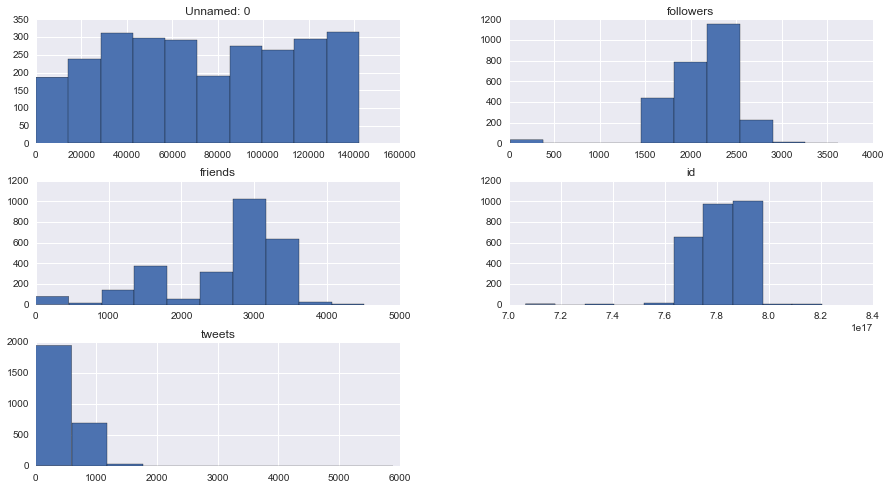

In [16]:
moscow_users.hist()

In [23]:
moscow_users[:10]

,Unnamed: 0,created_at,favorites,followers,friends,id,location,name,screen_name,tweets
68,68.0,2016-09-13 17:13:21,72,2420,3400.0,7.757442e+17,Москва,Беляева Глафира,nekrasovamanue6,381.0
80,80.0,2016-10-20 05:03:57,79,1913,2134.0,7.889690e+17,Москва,Владимирова Вера,olegmh4bragin,173.0
164,164.0,2016-09-13 21:20:18,93,2515,3166.0,7.758063e+17,Москва,Маслова Василиса,LiveriyTurov,395.0
217,217.0,2016-09-13 20:04:14,121,1941,1706.0,7.757872e+17,Москва,Савельева Екатерина,EvmeniyShchukin,805.0
346,346.0,2016-09-13 22:30:53,62,2602,3273.0,7.758241e+17,Москва,Савельева Юлия,zigfridazaytse1,279.0
422,422.0,2016-09-13 13:00:50,58,2556,3085.0,7.756806e+17,Москва,Катя Самсонова,alma_maksimova,267.0
437,437.0,2016-08-11 15:44:33,101,1786,1518.0,7.637630e+17,Москва,Давыдова Ираида,PalladiyaIlina,1053.0
593,593.0,2016-09-13 19:22:10,63,2303,3383.0,7.757766e+17,Москва,Баранова Глафира,karl_lobanov,359.0
775,775.0,2016-09-13 10:19:52,71,2361,3345.0,7.756401e+17,Москва,Самойлова Евпраксия,sharapova_nila,337.0
849,849.0,2016-10-24 18:55:30,55,2556,3133.0,7.906278e+17,Москва,Хохлова Лидия,artyomthw,497.0


In [24]:
print("Total found: %s" % moscow_users.count()[0])

Total found: 2668


In [27]:
moscow_users.to_csv("./botnet_moscow.csv", encoding="utf8")

## Conclusion

Someone back in 2016 fall built small very deep linked botnet about 3k members.
Every bot has random photo (all same size) and random background image. 
Every bot post cites and photos. Some have ad retweets. 
Looks like names created by some "faker" library. Screen name and Profile name doesn't have any correlations.